<a href="https://colab.research.google.com/github/Chloehjj/Chloehjj/blob/main/Big_Data_group_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final project - Pneumonia Detection with Chest X-Ray Images**



Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli. Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable.

Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases. Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system.

Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis. The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.



##0. Install Java Script, PySpark and Spark NLP, and dependecies

For a better perfomance in the ViT part, use your GPU  instead of the CPU. Choose this option before running the code since this will restart the session

In [ ]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"

!pip -q install pyspark==3.4.1 spark-nlp==5.2.0

In [ ]:
import sparknlp
spark = sparknlp.start()

In [ ]:
import os
import pyspark.sql.functions as F
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset, Image
from sparknlp.base import ImageAssembler
from sparknlp.annotator import ViTForImageClassification
from pyspark.ml import Pipeline

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

##1. Load data


### Description of the Pneumonia Dataset

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [ ]:
train_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/*"
test_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/*"
val_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/val/*"
base_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"

Dataframes

Train / Val / Test Preview

In [ ]:
imageDF_train = (
    spark.read
    .format("image")
    .option("dropInvalid", value=True)
    .option("recursiveFileLookup", "true")
    .load(train_path)
    .withColumn(
        "folder",
        F.reverse(F.split(F.col("image.origin"), "/"))[1]
    )
    .withColumn(
        "label",
        F.when(F.col("folder") == "PNEUMONIA", F.lit(1)).otherwise(F.lit(0))
    )
)

imageDF_train.select("image.origin", "folder", "label").show(10, truncate=False)

+------------------------------------------------------------------------------------------------+------+-----+
|origin                                                                                          |folder|label|
+------------------------------------------------------------------------------------------------+------+-----+
|file:///kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1257-0001.jpeg     |NORMAL|0    |
|file:///kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1018-0001.jpeg     |NORMAL|0    |
|file:///kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1050-0001.jpeg     |NORMAL|0    |
|file:///kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0602-0001.jpeg     |NORMAL|0    |
|file:///kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1302-0001.jpeg     |NORMAL|0    |
|file:///kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0774-0001.jpeg     |NORMAL

In [ ]:
print( "0 for Normal, 1 for Pneumonia")
imageDF_train.groupBy("label").count().show()

0 for Normal, 1 for Pneumonia
+-----+-----+
|label|count|
+-----+-----+
|    0| 1341|
|    1| 3875|
+-----+-----+



In [ ]:
imageDF_test = (
    spark.read
    .format("image")
    .option("dropInvalid", value=True)
    .option("recursiveFileLookup", "true")
    .load(test_path)
    .withColumn(
        "folder",
        F.reverse(F.split(F.col("image.origin"), "/"))[1]
    )
    .withColumn(
        "label",
        F.when(F.col("folder") == "PNEUMONIA", F.lit(1)).otherwise(F.lit(0))
    )
)

imageDF_test.select("image.origin", "folder", "label").show(10, truncate=False)

+------------------------------------------------------------------------------------------+------+-----+
|origin                                                                                    |folder|label|
+------------------------------------------------------------------------------------------+------+-----+
|file:///kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0045-0001.jpeg        |NORMAL|0    |
|file:///kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0025-0001.jpeg        |NORMAL|0    |
|file:///kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0282-0001.jpeg|NORMAL|0    |
|file:///kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0035-0001.jpeg        |NORMAL|0    |
|file:///kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0029-0001.jpeg        |NORMAL|0    |
|file:///kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0013-0001.jpeg        |NORMAL|0    |
|file:///kaggle/input/chest-xray-pneumonia/che

In [ ]:
imageDF_val = (
    spark.read
    .format("image")
    .option("dropInvalid", value=True)
    .option("recursiveFileLookup", "true")
    .load(val_path)
    .withColumn(
        "folder",
        F.reverse(F.split(F.col("image.origin"), "/"))[1]
    )
    .withColumn(
        "label",
        F.when(F.col("folder") == "PNEUMONIA", F.lit(1)).otherwise(F.lit(0))
    )
)

imageDF_val.select("image.origin", "folder", "label").show(10, truncate=False)

+------------------------------------------------------------------------------------------------+---------+-----+
|origin                                                                                          |folder   |label|
+------------------------------------------------------------------------------------------------+---------+-----+
|file:///kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg       |NORMAL   |0    |
|file:///kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg       |NORMAL   |0    |
|file:///kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg       |NORMAL   |0    |
|file:///kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg       |NORMAL   |0    |
|file:///kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg       |NORMAL   |0    |
|file:///kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1436

In [ ]:
print("Train label distribution:")
imageDF_train.groupBy("label").count().show()

print("Val label distribution:")
imageDF_val.groupBy("label").count().show()

print("Test label distribution:")
imageDF_test.groupBy("label").count().show()

Train label distribution:
+-----+-----+
|label|count|
+-----+-----+
|    0| 1341|
|    1| 3875|
+-----+-----+

Val label distribution:
+-----+-----+
|label|count|
+-----+-----+
|    0|    8|
|    1|    8|
+-----+-----+

Test label distribution:
+-----+-----+
|label|count|
+-----+-----+
|    0|  234|
|    1|  390|
+-----+-----+



* The training set exhibits severe imbalance, pneumonia cases significantly outnumber normal cases (approximately 3-fold). This bias causes the model to pretend to predict pneumonia.

In [ ]:
# Check image size variation
imageDF_train.select(
    F.col("image.width").alias("w"),
    F.col("image.height").alias("h")
).groupBy("w","h").count().orderBy(F.desc("count")).show(10)

+----+---+-----+
|   w|  h|count|
+----+---+-----+
|1072|648|    7|
|1080|728|    6|
|1216|872|    5|
|1064|760|    5|
|1008|680|    5|
|1008|704|    5|
| 976|672|    5|
| 992|592|    5|
|1176|760|    4|
|1128|736|    4|
+----+---+-----+
only showing top 10 rows



##2. Spark NLP's vision pipeline

In [ ]:
# Prepare the image for NLP
image_assembler = ImageAssembler() \
    .setInputCol("image") \
    .setOutputCol("image_assembler")

# Using a specific pre-trained model often helps avoid runtime errors
image_classifier = ViTForImageClassification.pretrained("image_classifier_vit_base_patch16_224", "en") \
    .setInputCols("image_assembler") \
    .setOutputCol("class")

pipe = Pipeline(stages=[image_assembler, image_classifier])
model = pipe.fit(imageDF_train)
out = model.transform(imageDF_train)

out.select("image.origin", "folder", "label", "class.result").show(5, truncate=False)

image_classifier_vit_base_patch16_224 download started this may take some time.
Approximate size to download 309.7 MB
[OK!]
+-------------------------------------------------------------------------------------------+------+-----+------------------------------------+
|origin                                                                                     |folder|label|result                              |
+-------------------------------------------------------------------------------------------+------+-----+------------------------------------+
|file:///kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1257-0001.jpeg|NORMAL|0    |[television, television system]     |
|file:///kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1018-0001.jpeg|NORMAL|0    |[screw]                             |
|file:///kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1050-0001.jpeg|NORMAL|0    |[nematode, nematode worm, roundworm]|
|file:///kag

In [ ]:
# Make a validation split
train_df, val_df = imageDF_train.randomSplit([0.8, 0.2], seed=42)

In [ ]:
pred_val = model.transform(val_df)

In [ ]:
# Extract predicted label from Spark NLP output
pred_val.select("class.result").show(5, truncate=False)

+------------------------------------+
|result                              |
+------------------------------------+
|[screw]                             |
|[television, television system]     |
|[nematode, nematode worm, roundworm]|
|[screw]                             |
|[television, television system]     |
+------------------------------------+
only showing top 5 rows



* The pretrained ViT model produced ImageNet object labels (e.g. 'screw', 'television'), confirming that it is not task-aligned with chest X-ray pneumonia classification and therefore was used only as a baseline demonstration of Spark NLP's vision pipeline. Consequently, further fine-tuning is required.

## 3. Vision Transformer (ViT) Deep Learning

In [ ]:
data_files = {
    "train": f"{base_path}/train/**/*",
    "validation": f"{base_path}/val/**/*",  # we are changing "val" to "validation" because some functions read automatically "validation"
    "test": f"{base_path}/test/**/*"
}

3.1. **ViT Preprocessing** <br> <br>
Here, we are using Deep Learning's framework PyTorch with a pre-trained Hugging Face model. We are going to fine-tune this pre-trained model for our x-ray problem. Training a whole new model could take even months and many big datasets <br> <br>

We used this for the training due to 2 main reasons:
- The industry standard for training complex Deep Learning models, like Vision Transformers, is usually PyTorch, among others.
- Open-source limitations with Spark NLPs for fine-tuning.

Thus, we decided to use PyTorch for the training and Spark for the inference.

Sources: https://huggingface.co/google/vit-base-patch16-224-in21k

https://docs.databricks.com/aws/en/machine-learning/train-model/dl-best-practices

In [ ]:
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer

In [ ]:
ds = load_dataset("imagefolder", data_files=data_files, drop_labels=False)

Resolving data files:   0%|          | 0/5216 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/624 [00:00<?, ?it/s]

In [ ]:
model_name = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name)

def transform(example_batch):
    # Convertimos a RGB para evitar errores de canales
    inputs = processor([x.convert("RGB") for x in example_batch['image']], return_tensors='pt')
    inputs['labels'] = example_batch['label']
    return inputs

ds_prepared = ds.with_transform(transform)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


3.2. Training configuration

In [ ]:
labels = ds["train"].features["label"].names
label2id = {label: str(i) for i, label in enumerate(labels)}
id2label = {str(i): label for i, label in enumerate(labels)}

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

def compute_metrics(p):
    return {"accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))}

training_args = TrainingArguments(
    output_dir="./vit_final_output",
    seed=42,
    fp16=True,
    dataloader_num_workers=2,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    eval_strategy="steps",
    save_steps=100,
    eval_steps=100,
    logging_steps=50,
    learning_rate=2e-4,
    save_total_limit=1,
    remove_unused_columns=False,
    report_to='none',
    load_best_model_at_end=True,
    dataloader_pin_memory=False
)


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=ds_prepared["train"],
    eval_dataset=ds_prepared["validation"],
    compute_metrics=compute_metrics,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


3.3. Train the model

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,0.089200,0.068359,1.000000
200,0.017200,0.010508,1.000000


TrainOutput(global_step=246, training_loss=0.07283087959134482, metrics={'train_runtime': 379.5394, 'train_samples_per_second': 41.229, 'train_steps_per_second': 0.648, 'total_flos': 1.2125946534891356e+18, 'train_loss': 0.07283087959134482, 'epoch': 3.0})

As our model is already trained, we're going to evalutate it.





In [ ]:
print(trainer.evaluate(ds_prepared["test"]))

{'eval_loss': 0.9655911326408386, 'eval_accuracy': 0.782051282051282, 'eval_runtime': 15.6971, 'eval_samples_per_second': 39.752, 'eval_steps_per_second': 4.969, 'epoch': 3.0}


To get a better insight, we'll look at the predictions for our test set and the confusion matrix

<br> <br>
3.4. Test's actual values vs predictions

In [ ]:
test_results = trainer.predict(ds_prepared["test"])  # to obtain raw probabilities

#Now, we transform the probabilities into their winning clas (0 or 1)
y_pred_id = np.argmax(test_results.predictions, axis=1)
y_true_id = test_results.label_ids

#The model saves internally what is 0 and what is 1. Now, we recover our labels' names
id2label = model.config.id2label
y_pred_name = [id2label[str(i)] for i in y_pred_id]
y_true_name = [id2label[str(i)] for i in y_true_id]

#Now, let's use these results and present it with a useful comparative table!!
df_results = pd.DataFrame({
    "Reality": y_true_name,
    "Prediction": y_pred_name,
    "Right guess": [x == y for x, y in zip(y_true_name, y_pred_name)]
})

#First 10 rows
print("\n First 10 predictions:")
print(df_results.head(10))

#First 10 errors (false negatives and false positives)

print(df_results[df_results["Right guess"] == False].head(10))


 First 10 predictions:
  Reality Prediction  Right guess
0  NORMAL  PNEUMONIA        False
1  NORMAL  PNEUMONIA        False
2  NORMAL     NORMAL         True
3  NORMAL  PNEUMONIA        False
4  NORMAL  PNEUMONIA        False
5  NORMAL     NORMAL         True
6  NORMAL  PNEUMONIA        False
7  NORMAL  PNEUMONIA        False
8  NORMAL  PNEUMONIA        False
9  NORMAL     NORMAL         True
   Reality Prediction  Right guess
0   NORMAL  PNEUMONIA        False
1   NORMAL  PNEUMONIA        False
3   NORMAL  PNEUMONIA        False
4   NORMAL  PNEUMONIA        False
6   NORMAL  PNEUMONIA        False
7   NORMAL  PNEUMONIA        False
8   NORMAL  PNEUMONIA        False
11  NORMAL  PNEUMONIA        False
14  NORMAL  PNEUMONIA        False
16  NORMAL  PNEUMONIA        False


3.4.1. Confusion matrix

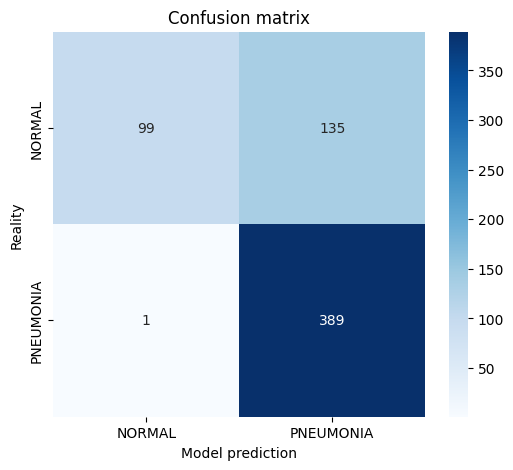

In [ ]:
cm = confusion_matrix(y_true_name, y_pred_name, labels=list(id2label.values()))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=id2label.values(),
            yticklabels=id2label.values())
plt.xlabel('Model prediction')
plt.ylabel('Reality')
plt.title('Confusion matrix')
plt.show()

* The confusion mtrix shows a strong asymmetry, only 1 false negative for pneumonia, which pneumonia is predicted as normal, while 135 normal cases are misclassified as pneumonia, meaning the dominant errors are false positives for the pneumonia class.

3.4.2. Our model's metrics

In [ ]:
print("\n Classification information:")
print(classification_report(y_true_name, y_pred_name))


 Classification information:
              precision    recall  f1-score   support

      NORMAL       0.99      0.42      0.59       234
   PNEUMONIA       0.74      1.00      0.85       390

    accuracy                           0.78       624
   macro avg       0.87      0.71      0.72       624
weighted avg       0.84      0.78      0.75       624



* The NORMAL recall = 0.42 representing the misclassified as pneumonia, about 42% of normal samples are modelled as pneumonia.
* The PNEUMONIA recall = 1.00 demonstrates little chance of missing diagnosis.
* The NORMAL precision = 0.99, which means the model adopts a conservative approach to classifying instances as normal, only assigning this label with high certainty.
* The PNEUMONIA precision = 0.74, representing the samples classified as pneumonia by the model, approximately 26% were actually normal, which this constitutes the source of false positives.

In summary, the model tends to judge all suspicious samples as pneumonia, ensuring that no diagnosis is missed, but at the cost of more normal false positives.

In [ ]:
trainer.save_model("./final_model_pneumonia")

Now, our model is saved. Ready to use it for diagnosis predictions for huge datasets in Spark!!

# 4. Conclusions

Our results show that the ViT model needs task-specific adaptation to be useful on chest X-ray pneumonia classification. When we directly applied the ImageNet pre-trained ViT, the predicted labels were in the category of everyday objects rather than 'normal/pneumonia', suggesting that the generic vision classifier cannot be directly applied to this medical task without fine-tuning.

After fine-tuning ViT on the pneumonia dataset, we obtained a test accuracy of 0.78. The pneumonia recall reached 1.00, which means the error pattern is not balances, and this model almost not misses pneumonia cases, but the normal recall was only 0.42, so many normal images were flagged as pneumonia.

In practice, this appears to be a model that is highly cautious in its predictions of 'normal' conditions, often over-labelling pneumonia when faced with uncertainty, which can lead to unstable model selection.